In [ ]:
#https://github.com/jleuschen17/EE399/tree/master/homework5

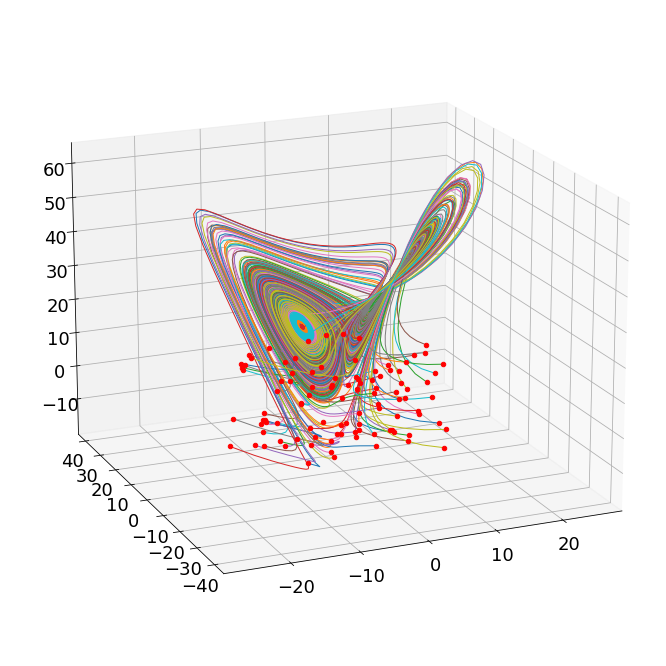

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import integrate
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import tensorflow_addons as tfa
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

dt = 0.01
T = 8
t = np.arange(0, T + dt, dt)
beta = 8 / 3
sigma = 10
rho = 28

nn_input = np.zeros((100 * (len(t) - 1), 3))
nn_output = np.zeros_like(nn_input)

fig, ax = plt.subplots(1, 1, subplot_kw={'projection': '3d'})


def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
    x, y, z = x_y_z
    return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]


np.random.seed(123)
x0 = -15 + 30 * np.random.random((100, 3))

x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t)
                  for x0_j in x0])


for j in range(100):
    nn_input[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, :-1, :]
    nn_output[j * (len(t) - 1):(j + 1) * (len(t) - 1), :] = x_t[j, 1:, :]
    x, y, z = x_t[j, :, :].T
    ax.plot(x, y, z, linewidth=1)
    ax.scatter(x0[j, 0], x0[j, 1], x0[j, 2], color='r')

ax.view_init(18, -113)
plt.show()

In [8]:
print(x_t[0, :-1, :])
print(x_t[0, 1:, :])

[[ 5.89407557 -6.41581995 -8.19445639]
 [ 4.82193361 -4.42932378 -8.2637822 ]
 [ 4.02291799 -2.79797594 -8.20303867]
 ...
 [-3.1452048  -3.9380816  18.680526  ]
 [-3.23320728 -4.20036458 18.31696423]
 [-3.33865683 -4.48070955 17.97565058]]
[[ 4.82193361 -4.42932378 -8.2637822 ]
 [ 4.02291799 -2.79797594 -8.20303867]
 [ 3.44161713 -1.43399725 -8.06458898]
 ...
 [-3.23320728 -4.20036458 18.31696423]
 [-3.33865683 -4.48070955 17.97565058]
 [-3.46168409 -4.78061756 17.65794547]]


In [ ]:

models = {}
rhos = [10, 28, 40]
print("DEFINED")
for rho in rhos:
    print(rho)
    models[rho] = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(3,)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(3)
    ])
print("compiling models")
for rho in rhos:
    models[rho].compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

for rho in rhos:
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
    for j in range(100):
        nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]
    print("Training models")
    models[rho].fit(nn_input, nn_output, epochs=25, batch_size=100, verbose=1)


test_rhos = [17, 35]
results = {}

for rho in test_rhos:
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    for rho2 in rhos:
        x_test = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])


        test_input = x_test[:, :-1, :].reshape(-1, 3)

        predictions = models[rho2].predict(test_input)

        predictions = predictions.reshape(x_test.shape[0], -1, 3)

        mse = np.mean((predictions - x_test[:, 1:, :]) ** 2)

        results[(rho, rho2)] = mse

for (i, j) in results:
    print(f"Score for {i, j}: {results[(i, j)]}")



In [63]:

esn_models = {}
lstm_models = {}
rnn_models = {}

for rho in rhos:
    lstm_models[rho] = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(32, activation='relu', input_shape=(1, 3), return_sequences=True),
        tf.keras.layers.LSTM(32, activation='relu'),
        tf.keras.layers.Dense(3)
    ])

    rnn_models[rho] = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(32, activation='relu', input_shape=(1, 3), return_sequences=True),
        tf.keras.layers.SimpleRNN(32, activation='relu'),
        tf.keras.layers.Dense(3)
    ])
    esn_models[rho] = tf.keras.models.Sequential([
        tfa.layers.ESN(32, activation='relu', input_shape=(1, 3), return_sequences=True),
        tfa.layers.ESN(32, activation='relu'),
        tf.keras.layers.Dense(3)
    ])

for rho in rhos:
    lstm_models[rho].compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
    rnn_models[rho].compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')
    esn_models[rho].compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='mse')

for rho in rhos:
    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    x_t = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])
    for j in range(100):
        nn_input[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,:-1,:]
        nn_output[j*(len(t)-1):(j+1)*(len(t)-1),:] = x_t[j,1:,:]

    print(f"Training LSTM model for rho: {rho}")
    lstm_models[rho].fit(np.expand_dims(nn_input, axis=1), nn_output, epochs=10, batch_size=64, verbose=1)
    print(f"Training RNN model for rho: {rho}")
    rnn_models[rho].fit(np.expand_dims(nn_input, axis=1), nn_output, epochs=10, batch_size=64, verbose=1)
    print(f"Training ESN model for rho: {rho}")
    esn_models[rho].fit(np.expand_dims(nn_input, axis=1), nn_output, epochs=10, batch_size=64, verbose=1)


test_lstm_results = {}
test_rnn_results = {}
test_esn_results = {}

for rho in test_rhos:

    def lorenz_deriv(x_y_z, t0, sigma=sigma, beta=beta, rho=rho):
        x, y, z = x_y_z
        return [sigma * (y - x), x * (rho - z) - y, x * y - beta * z]

    for rho2 in rhos:
        x_test = np.asarray([integrate.odeint(lorenz_deriv, x0_j, t) for x0_j in x0])

        test_input = x_test[:, :-1, :].reshape(-1, 3)

        lstm_predictions = lstm_models[rho2].predict(np.expand_dims(test_input, axis=1))
        rnn_predictions = rnn_models[rho2].predict(np.expand_dims(test_input, axis=1))
        esn_predictions = esn_models[rho2].predict(np.expand_dims(test_input, axis=1))

        lstm_predictions = lstm_predictions.reshape(x_test.shape[0], -1, 3)
        rnn_predictions = rnn_predictions.reshape(x_test.shape[0], -1, 3)
        esn_predictions = esn_predictions.reshape(x_test.shape[0], -1, 3)


        lstm_mse = np.mean((lstm_predictions - x_test[:, 1:, :])**2)
        rnn_mse = np.mean((rnn_predictions - x_test[:, 1:, :])**2)
        esn_mse = np.mean((esn_predictions - x_test[:, 1:, :])**2)

        test_lstm_results[(rho, rho2)] = lstm_mse
        test_rnn_results[(rho, rho2)] = rnn_mse
        test_esn_results[(rho, rho2)] = esn_mse



print("Results for LSTM models:")
for (i, j) in test_lstm_results:
    print(f"Score for {i, j}: {test_lstm_results[(i, j)]}")

print("Results for RNN models:")
for (i, j) in test_rnn_results:
    print(f"Score for {i, j}: {test_rnn_results[(i, j)]}")

print("Results for ESN models:")
for (i, j) in test_esn_results:
    print(f"Score for {i, j}: {test_esn_results[(i, j)]}")


Training LSTM model for rho: 10
Epoch 1/10
1250/1250 [==============================] - 4s 3ms/step - loss: 2.4954
Epoch 2/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0061
Epoch 3/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0022
Epoch 4/10
1250/1250 [==============================] - 3s 3ms/step - loss: 0.0013
Epoch 5/10
1250/1250 [==============================] - 3s 3ms/step - loss: 8.7367e-04
Epoch 6/10
1250/1250 [==============================] - 3s 3ms/step - loss: 8.3471e-04
Epoch 7/10
1250/1250 [==============================] - 3s 3ms/step - loss: 6.5989e-04
Epoch 8/10
1250/1250 [==============================] - 3s 3ms/step - loss: 6.1723e-04
Epoch 9/10
1250/1250 [==============================] - 3s 3ms/step - loss: 5.6148e-04
Epoch 10/10
1250/1250 [==============================] - 3s 3ms/step - loss: 5.4006e-04
Training RNN model for rho: 10
Epoch 1/10
1250/1250 [==============================] - 3s 2ms/step - loss: 1.6802

Score for (17, 10): 0.0472684074568874
Score for (17, 28): 0.09034684125173521
Score for (17, 40): 0.3974588104508566
Score for (35, 10): 0.5181165348005903
Score for (35, 28): 0.06629825489183239
Score for (35, 40): 0.07582859700073742